<a href="https://colab.research.google.com/github/mohammadsanatabassum/labs-and-projects-on-aiml-/blob/main/Manifold_learning_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Module 2: Appreciating, Interpreting and Visualizing Data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets

In [8]:
n_points = 900
X, color = datasets.make_s_curve(n_points, random_state=0)

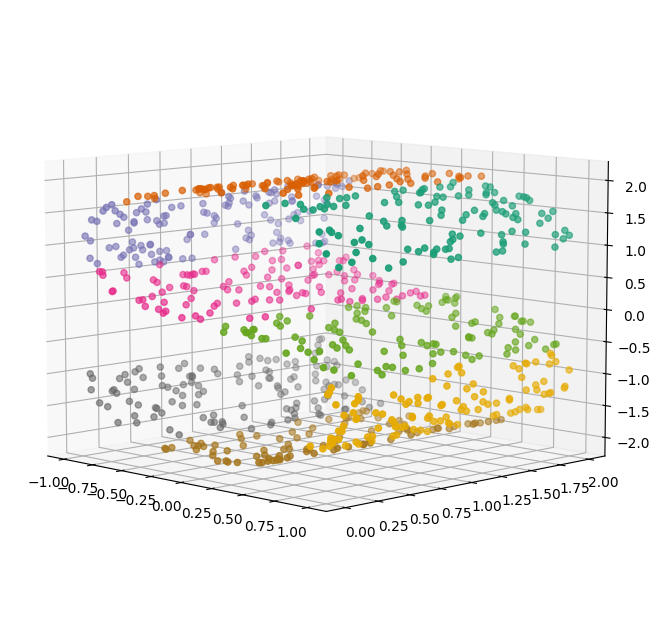

In [4]:
fig = plt.figure(figsize=(50, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.Dark2)
ax.view_init(8, -45)

In [9]:
def dist(a, b):
  '''Computes Euclidean distance between 2 points'''
  return np.sqrt(sum((a - b) ** 2))

distances = np.array([[dist(p1, p2) for p2 in X] for p1 in X])

print(distances.shape)

(900, 900)


In [10]:

n_neighbors = 25
neighbors = np.zeros(distances.shape)

sort_distances = np.argsort(distances, axis=1)[:, 1:n_neighbors+1]
for k,i in enumerate(sort_distances):
    neighbors[k,i] = distances[k,i]

In [11]:
neighbors.shape

(900, 900)

In [12]:
from scipy.sparse.csgraph import shortest_path

graph = shortest_path(neighbors, directed=False)

In [13]:
gram = (graph ** 2)

In [14]:
n_samples = gram.shape[0]

# Mean for each row/column
meanrows = np.sum(gram, axis=0) / n_samples
meancols = (np.sum(gram, axis=1)/n_samples)[:, np.newaxis]
meanall = meanrows.sum() / n_samples

gram -= meanrows
gram -= meancols
gram += meanall

In [15]:

eig_val_cov, eig_vec_cov = np.linalg.eig(gram)

eig_pairs = [(np.abs(eig_val_cov[i]), eig_vec_cov[:, i]) for i in range(len(eig_val_cov))]

# We want to reduce the dimensionality to **n_components** dimensions, therefore we will be first taking the top **n_components** eigenvectors (sorted in descending by eigenvalues)
eig_pairs.sort(key=lambda x: x[0], reverse=True)
eig_pa_chebyshevirs = np.array(eig_pairs, dtype=object)
n_components = 2

reduced_matrix = np.zeros((n_components, gram.shape[1]))
for i in range(n_components):
  reduced_matrix[i,:] = eig_pa_chebyshevirs[i,1]
reduced_matrix = reduced_matrix.T

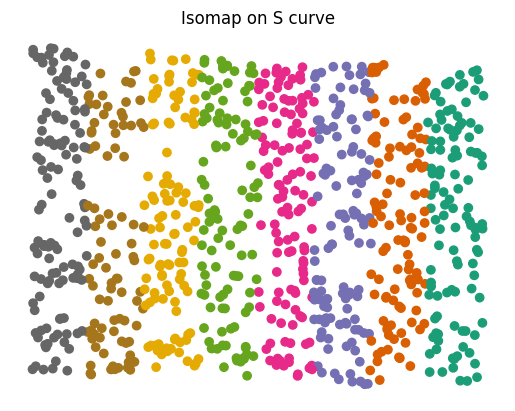

In [16]:
ax = fig.add_subplot(111)
plt.scatter(reduced_matrix[:, 0], reduced_matrix[:, 1], c=color, cmap=plt.cm.Dark2)
plt.title("Isomap on S curve")
plt.axis('off')
plt.show()

In [17]:
from sklearn.manifold import Isomap

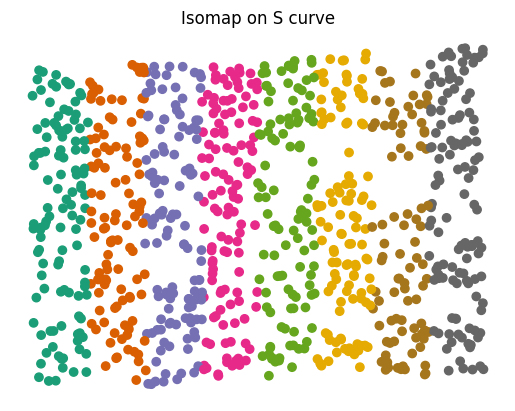

In [18]:
Y = Isomap(n_neighbors=25, n_components=2).fit_transform(X)

ax = fig.add_subplot(111)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Dark2)
plt.title("Isomap on S curve")
plt.axis('off')
plt.show()

In [19]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=200)
faces.data.shape

(766, 2914)

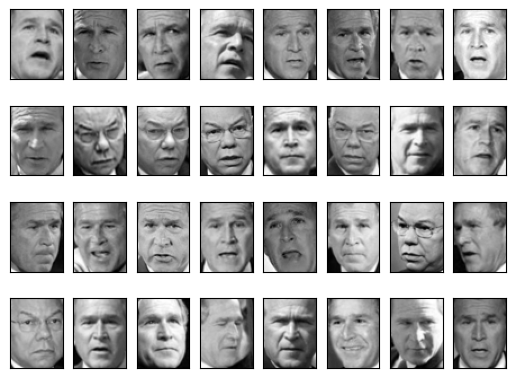

In [20]:
fig, ax = plt.subplots(4, 8, subplot_kw=dict(xticks=[], yticks=[]))
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='gray')

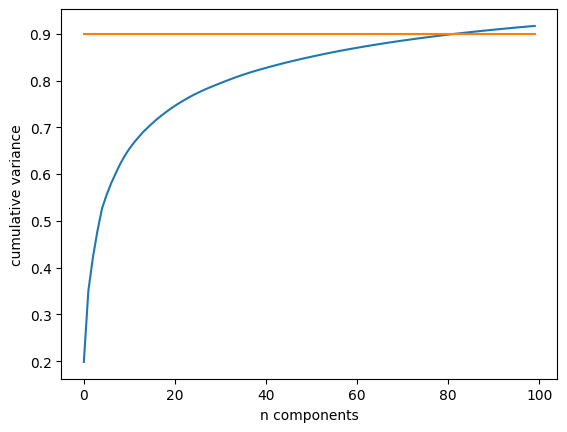

In [21]:
from sklearn.decomposition import PCA as RandomizedPCA
model = RandomizedPCA(100).fit(faces.data)
plt.plot(np.cumsum(model.explained_variance_ratio_))
plt.xlabel('n components')
plt.ylabel('cumulative variance')
plt.plot(range(100), 0.9*np.ones(100))

In [22]:
model = Isomap(n_components=2, n_neighbors = 5)
proj = model.fit_transform(faces.data)
proj.shape

(766, 2)

In [23]:
from matplotlib import offsetbox

def plot_components(data, model, images=None, ax=None, thumb_frac=0.05, cmap='gray'):

    ax = ax or plt.gca()
    proj = model.fit_transform(data)
    ax.plot(proj[:, 0], proj[:, 1], '.k')

    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:

                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], cmap=cmap),
                                      proj[i])
            ax.add_artist(imagebox)

Text(0, 0.5, 'Image Darkness')

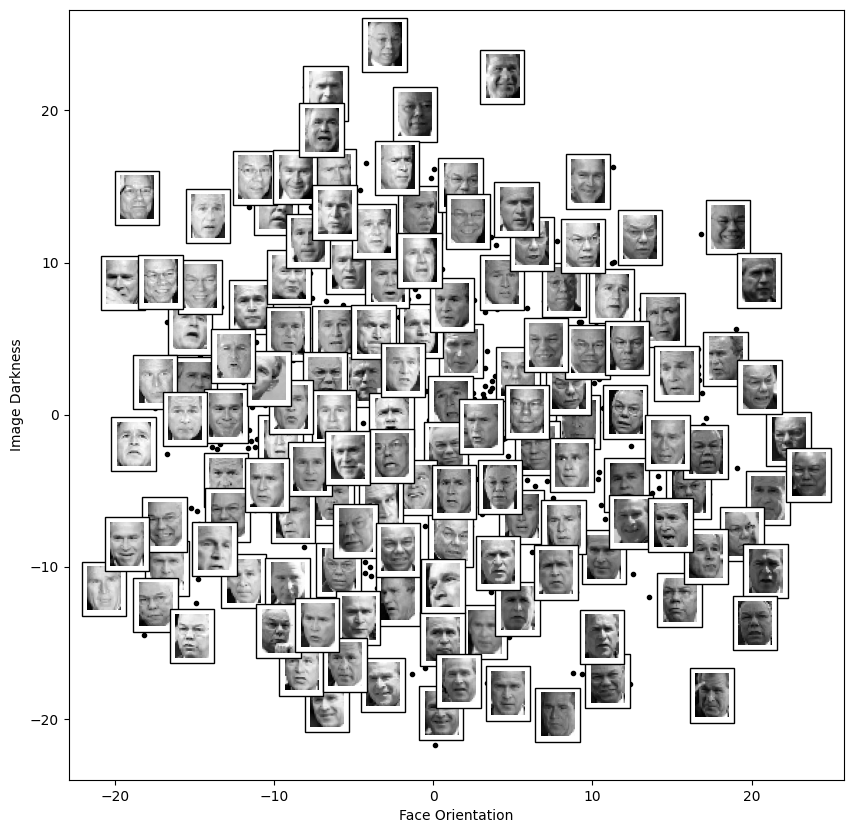

In [24]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_components(faces.data,
                model=Isomap(n_components=2, n_neighbors = 5),
                images=faces.images[:, ::2, ::2])
plt.xlabel("Face Orientation")
plt.ylabel("Image Darkness")

Exercises!!

    How do you think would the number of neighbors effect the Isomap algorithm? What happens when the number of neighbors considered is very large? What happens when it is very low?

    When is the ISOMAP algorithm superior to PCA?

    Search up another manifold learning methods other than ISOMAP? If there are any, whats the key difference ?

    Suggest ways to deal with missing data in manifold learning.


The number of neighbors (denoted as k) directly influences the local geometry captured by the Isomap algorithm, which is based on nearest neighbor graphs.

    When k is very large: The Isomap algorithm considers too many points as neighbors, effectively capturing a global structure. This can lead to over-smoothing of the data, where fine-grained details of the manifold are lost, and the intrinsic geometry becomes too simple or too linear. The resulting graph may not adequately capture the true non-linear relationships, and dimensionality reduction could fail to preserve local structures.

    When k is very low: If only a few neighbors are considered, Isomap will focus too much on very local structure and might fail to capture the global manifold structure. The distance matrix (used for constructing geodesics) will not adequately represent the global relationships, and the embedding may result in poor or misleading results, such as disconnected clusters or inaccurate low-dimensional representations.

The Isomap algorithm is superior to PCA when the data lies on a non-linear manifold (i.e., the data is not globally linear). PCA performs linear dimensionality reduction, which assumes that the data's intrinsic structure can be represented by linear combinations of features. However, Isomap preserves non-linear relationships between data points, making it better for capturing the structure of data that follows complex, curved manifolds.

In summary:

    PCA is better for linearly distributed data.
    Isomap is superior when the data has a non-linear manifold structure that needs to be preserved.

Suggest ways to deal with missing data in manifold learning.

Dealing with missing data in manifold learning can be challenging, but several methods can be employed:

    Imputation techniques: Missing data can be imputed using methods like mean imputation, k-nearest neighbors (KNN), or regression models. This ensures that no data points are dropped and the manifold learning can proceed with the full dataset.

    Matrix completion: This approach assumes that the data matrix is low-rank, and missing values are inferred based on observed ones, often using methods like singular value decomposition (SVD) or Alternating Least Squares (ALS).

    Use algorithms that handle missing data: Some manifold learning algorithms, such as certain implementations of Isomap, have been extended to deal with missing data by approximating geodesic distances from the available data points.

    Exclude missing data: In cases where imputation may introduce noise, another option is to remove points or features with missing values, though this can lead to a loss of information.

    Distance-based approaches: Some algorithms modify the distance matrix computation to ignore missing values, either by using pairwise distance estimations based on available data or by weighting the neighbors appropriately.